# Jonathan Halverson
# Monday, April 11, 2016
# Iris and XOR with SVM

In [15]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('halverson')

In this notebook we work with only two features to aid in visualization:

In [16]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target

(0, 3)

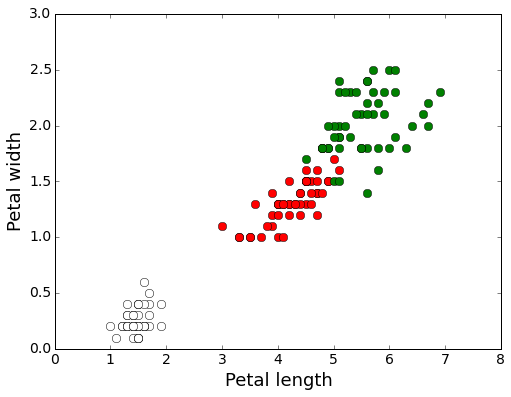

In [17]:
for clr, cls in zip(['white', 'red', 'green'], np.unique(y)):
    plt.plot(X[y == cls, 0], X[y == cls, 1], 'o', color=clr)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
plt.xlim(0, 8)
plt.ylim(0, 3)

### Preprocessing

We perform a test train split and then standardize the data even though it has been generated from a standard normal.

In [18]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [19]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)
X_std = stdsc.transform(X)

Let's assume the data is linearly separable. We proceed with SVM with a linear kernel. The goal of support vector machine is to maximize the margin. This is in contrast to the perceptron where the goal was to minimize classification errors. The margin is the distance between the training data points nearest to the hyperplane (decision boundary). The training samples that are closest to the hyperplane are called the support vectors. Quadratic programming is used to find the hyperplane that maximizes the margin subject to the constraint that the classes are correctly separated by the hyperplane.

In the case a data sets that are not perfectly linearly separable, to allow the optimization scheme to converge, the linear constraints are relaxed by the introduction of a so-called slack variable. The objective function to be minimized is

$$\frac{1}{2}||\boldsymbol{w}||^2+C\sum_i\xi_i,$$

where $\xi$ is the slack variable which leads to the soft-margin classification. The parameter C controls the penalty for misclassification. Large values of C correspond to large penalties. This parameter allows us to control the bias-variance trade-off. A larger margin is less likely to overfit or have a large generalization error.

Note the similarity between SVM and logistic regression with regularization. Also, logistic regression tends to be more prone to outlinears than SVMs since they consider all points while SVMs focus on points near the separating hyperplane (i.e., the support vectors). Logistic regression is simpler and useful for data streams.

### Linear SVM

In [20]:
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV

param_grid = dict(C=np.logspace(-3, 2, base=10))
grid = GridSearchCV(estimator=SVC(kernel='linear'), param_grid=param_grid, cv=10, scoring='accuracy')
grid.fit(X_train_std, y_train)
print grid.best_score_
print grid.best_params_

0.955357142857
{'C': 0.086851137375135293}


In [21]:
svm = SVC(kernel='linear', C=grid.best_params_['C'])
svm.fit(X_train_std, y_train)

SVC(C=0.086851137375135293, cache_size=200, class_weight=None, coef0=0.0,
  degree=3, gamma=0.0, kernel='linear', max_iter=-1, probability=False,
  random_state=None, shrinking=True, tol=0.001, verbose=False)

C is the penalty parameter of the error term. Next we evaluate the accuracy of the model on the test data:

In [22]:
svm.score(X_test_std, y_test)

1.0

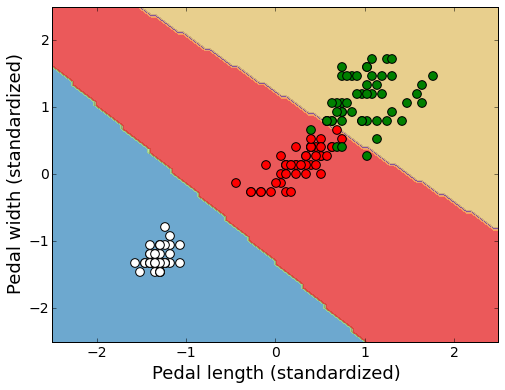

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=1)

# decision boundary plot
x_min, x_max = -2.5, 2.5
y_min, y_max = -2.5, 2.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, num=100), np.linspace(y_min, y_max, num=100))
Z = svm.predict(np.c_[xx.ravel(), yy.ravel()]) 
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
ax.set_xlabel("Pedal length (standardized)")
ax.set_ylabel("Pedal width (standardized)")
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)

# original data
for clr, cls in zip(['white', 'red', 'green'], np.unique(y)):
    ax.scatter(x=X_std[y == cls, 0], y=X_std[y == cls, 1], marker='o', c=clr, s=75)

### Nonlinearly separable cases

SVMs can be kernelized to solve nonliner classification problems. Consider the data set below:

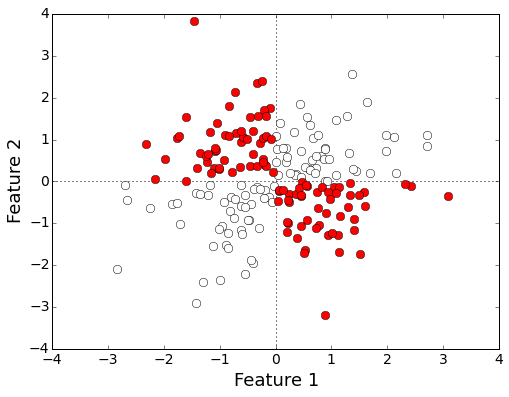

In [24]:
X_xor = np.random.randn(200, 2)
y_xor = np.logical_xor(X_xor[:,0] > 0, X_xor[:, 1] > 0)
y_xor = np.where(y_xor, 1, -1)
plt.plot([-4, 4], [0, 0], 'k:')
plt.plot([0, 0], [-4, 4], 'k:')
plt.plot(X_xor[y_xor == -1, 0], X_xor[y_xor == -1, 1], 'wo')
plt.plot(X_xor[y_xor == 1, 0], X_xor[y_xor == 1, 1], 'ro')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

The basic idea of nonlinear SVMs is to create nonlinear combinations of the features which brings about linear separation in a higher dimensional space. A mapping function is used for this purpose. When the data are projected back into the original space the decision boundary appears nonlinear. Note that the mapping function must be applied to new data in order to classify it.

Instead of calculating the dot product between two feature vectors explicitly, the mapping of the two feature vectors, $\phi(x_i) \phi(x_j)$, is used to reduce computational expense. The radial basis function kernel or Gaussian kernel is

$$k(x_i, x_j) = \exp(-\gamma ||x_i - x_j||^2)$$

where $||x_i - x_j||^2$ is the squared Euclidean distance between feature vectors and $\gamma = 1/2\sigma^2$. Large values of $\gamma$ lead to sharp decision boundaries and overfitting or high generalization error or high variance. $\gamma$ is a cut-off parameter for the Gaussian sphere. The term kernel can roughly be thought of as a similarity function between a pair of samples. $k(x_i, x_j)$ falls between a range of 0 (dissimilar samples) and 1 (similar).

In [25]:
X_xor_std = stdsc.fit_transform(X_xor)
param_grid = dict(C=np.logspace(-3, 2, base=10), gamma=np.logspace(-3, 2, base=10))
grid = GridSearchCV(estimator=SVC(kernel='rbf'), param_grid=param_grid, cv=10, scoring='accuracy')
grid.fit(X_xor_std, y_xor)
print grid.best_score_
print grid.best_params_

0.98
{'C': 9.5409547634999434, 'gamma': 2.329951810515372}


In [26]:
svm = SVC(kernel='rbf', C=grid.best_params_['C'], gamma=grid.best_params_['gamma'])
svm.fit(X_xor_std, y_xor)

SVC(C=9.5409547634999434, cache_size=200, class_weight=None, coef0=0.0,
  degree=3, gamma=2.329951810515372, kernel='rbf', max_iter=-1,
  probability=False, random_state=None, shrinking=True, tol=0.001,
  verbose=False)

GridSearchCV was used to find the optimal values of C and gamma. It is very likely that this has led to overfitting. For applications it is advised to use a larger value of gamma.

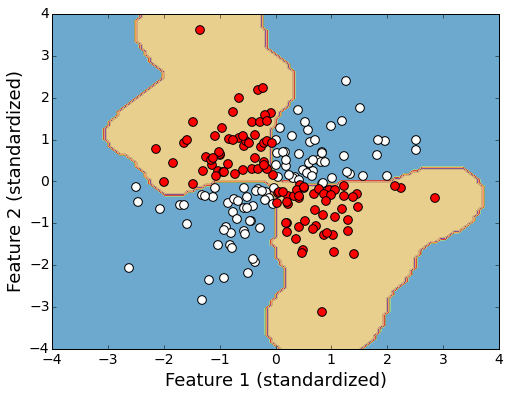

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=1)

# decision boundary plot
x_min, x_max = -4, 4
y_min, y_max = -4, 4
xx, yy = np.meshgrid(np.linspace(x_min, x_max, num=100), np.linspace(y_min, y_max, num=100))
Z = svm.predict(np.c_[xx.ravel(), yy.ravel()]) 
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
ax.set_xlabel("Feature 1 (standardized)")
ax.set_ylabel("Feature 2 (standardized)")
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)

# original data
colors = ['white', 'red']
for idx, cls in enumerate(np.unique(y_xor)):
    ax.scatter(x=X_xor_std[y_xor == cls, 0], y=X_xor_std[y_xor == cls, 1], marker='o', c=colors[idx], s=75)

### Large data sets and SGDClassifier

When the data set is too large to fit in memory the following models can be employed:

In [28]:
from sklearn.linear_model import SGDClassifier
lr = SGDClassifier(loss='log')
svm = SGDClassifier(loss='hinge')